Código para implementar SegNet-VGG16

In [72]:
#importa paquetes y bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
import os
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout,concatenate, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras import backend as K
from keras.optimizers import Adam
from keras.layers.core import SpatialDropout2D
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [73]:
#Cargar los datos
trainx_rgb = sorted(glob.glob('./dataset/trainx/*.png'), key=numericalSort) #lee el conjunto de datos "trainx" contiene las imagenes rgb
X_train = np.array([np.array(Image.open(fname)) for fname in trainx_rgb])

trainy_mask = sorted(glob.glob('./dataset/trainyy/*.png'), key=numericalSort) # lee el conjunto de datos "trainyy 2 contiene las imagenes binarias
Y_train = np.array([np.array(Image.open(fname)) for fname in trainy_mask])

In [74]:
#funcion para reajustar las imágenes a 256x192
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)

X_train_resized = []
Y_train_resized = []

for i in range(len(trainx_rgb)):
    X_train_resized.append(resize(trainx_rgb[i]))
    Y_train_resized.append(resize(trainy_mask[i]))
    
X_train = np.array([np.array(img) for img in X_train_resized])
Y_train = np.array([np.array(img) for img in Y_train_resized])

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

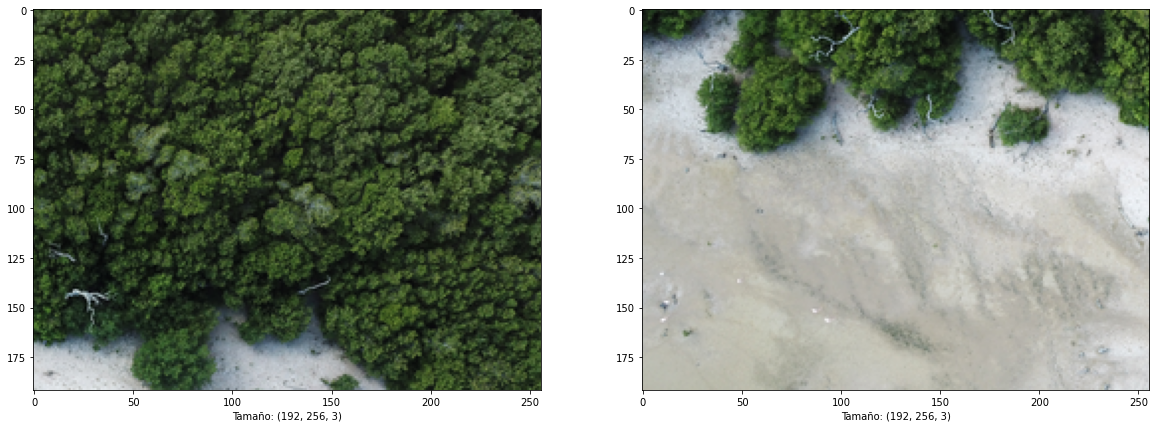

In [75]:
#Tamaño de las imágenes de entrada rgb
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.imshow(X_train[5])
plt.xlabel("Tamaño: "+str(np.array(X_train[1]).shape))
plt.subplot(1,2,2)
plt.imshow(X_train[10])
plt.xlabel("Tamaño: "+str(np.array(X_train[10]).shape))
plt.show()

In [ ]:
#tamaño de las máscaras binarias
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.imshow(Y_train[5], cmap = plt.cm.binary_r)
plt.subplot(1,2,2)
plt.imshow(Y_train[10], cmap = plt.cm.binary_r)
plt.show()

In [ ]:
#funciones para calcular las métricas de evaluación
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

#funcion para algunas técnicas de aummento de datos como rotación
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('float32')

#funcion para algunas técnicas de aummento de datos como volteo horizontal
def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('float32')

def vertical_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 0)
    y_image = cv2.flip(y_image.astype('float32'), 0)
    return x_image, y_image.astype('float32')

#def both_flip(x_image, y_image):
#    x_image = cv2.flip(x_image, -1)
#    y_image = cv2.flip(y_image.astype('float32'), -1)
#    return x_image, y_image.astype('float32')

#funcion para algunas técnicas de aummento de datos como volteo horizontal
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_vert = []
    y_vert = []
    #x_both = []
    #y_both = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = vertical_flip(x_train[idx], y_train[idx])
        x_vert.append(x)
        y_vert.append(y)
        
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip), np.array(x_vert), np.array(y_vert)

def img_augmentation(x_test, y_test):
   
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    x_vert = []
    y_vert = []
    #x_rotat = []
    #y_rotat =[]
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        
        x,y = vertical_flip(x_test[idx], y_test[idx])
        x_vert.append(x)
        y_vert.append(y)
        
        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip), np.array(x_vert), np.array(y_vert)

In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped, x_vertical, y_vertical = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t, x_vertical_t, y_vertical_t = img_augmentation(x_test, y_test)

In [ ]:
# Para el conjunto de entrenamiento
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Tamaño del conjunto de entrenamiento  : {}".format(len(x_train)))
print("Tamaño del conjunto de prueba       : {}".format(len(x_test)))
print("Tamaño del conjunto de validacion : {}".format(len(x_val)))

In [ ]:
#función para la arquitectura segnet
def segnet(epochs_num,savename):

    # Capa del codificador
    
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    
    # Capa del decodificador
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    
    
    model = Model(inputs=img_input, outputs=pred)
     
    model.compile(optimizer= Adam(lr = 0.003), loss= ['binary_crossentropy']
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 32, validation_data= (x_val, y_val), verbose=1)
    
    model.save(savename)
    return model,hist

In [ ]:
# Capa del codificador

img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)

# Capa del decodificador

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [ ]:
#carga el modelo con 120 épocas y guardar los pesos entrenados
model, hist = segnet(epochs_num= 120, savename= 'segnet_120_epoch.h5')

In [ ]:
#carga el modelo entrenado, el optimizador Adam y en la función de costo usamos entropia cruzada binaria
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= Adam(lr = 0.003), loss= ['binary_crossentropy']
              , metrics=[iou, dice_coef, precision, recall, accuracy])

In [ ]:
#cargamos los pesos entrenados
model_1.load_weights('segnet_120_epoch.h5')


In [ ]:
print('\n Estadisticas con 120 epocas sonre el conjunto de entrenamiento')
print('\n-------------Sobre el conjunto de entrenamiento--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Coef. Dice: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

In [ ]:
print('\n -> Sobre el conjunto de prueba <- \n')
res = model_1.evaluate(x_test, y_test, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Coef. Dice: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


In [ ]:
print('\n -> Sobre el conjunto de validación <- \n')
res = model_1.evaluate(x_val, y_val, batch_size = 48)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Coef. Dice: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')

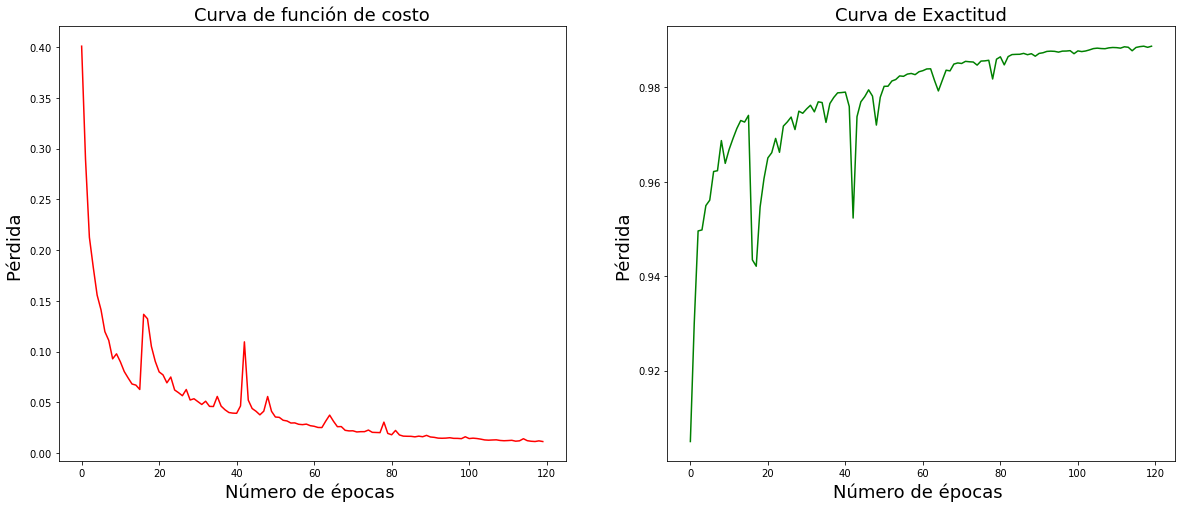

In [76]:
plt.figure(figsize=(20, 8))

#plt.suptitle('Estadistica de entrenamiento en el conjunto de entrenamiento', fontsize = 30, color='blue')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Curva de función de costo',fontsize = 18, color='black')
plt.xlabel("Número de épocas ",fontsize = 18, color='black')
plt.ylabel("Pérdida ",fontsize = 18, color='black')
#plt.subplot(2,3,2)
#plt.plot(hist.history['iou'], 'blue')
#plt.title('Jaccard Index',fontsize = 18, color='black')
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Curva de Exactitud',fontsize = 18, color='black')
plt.xlabel("Número de épocas ",fontsize = 18, color='black')
plt.ylabel("Pérdida ",fontsize = 18, color='black')
plt.show()
#plt.savefig('unet_train_1.png',dpi=200)

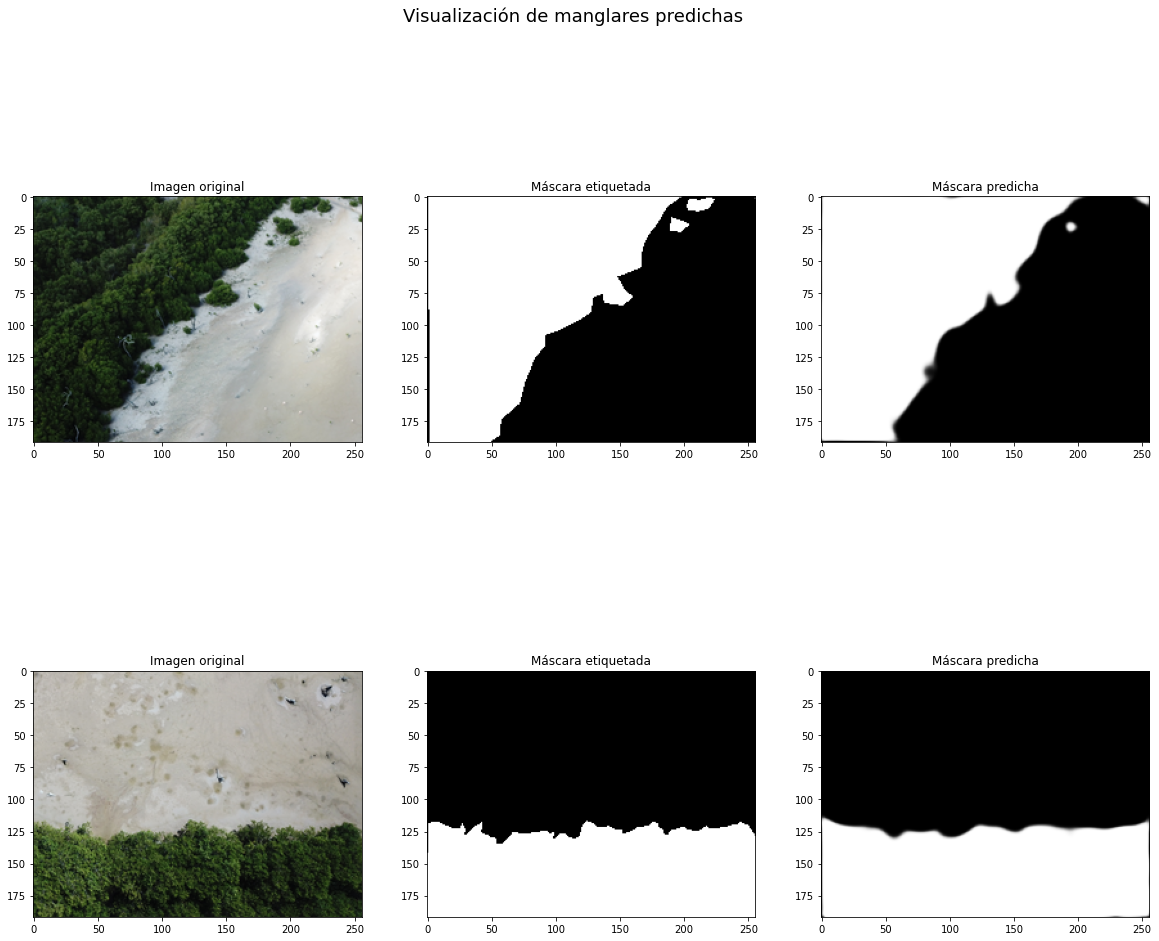

In [77]:
plt.figure(figsize=(20,16))

plt.suptitle('Visualización de manglares predichas', fontsize = 18, color='black')

img_pred = model_1.predict(x_test[49].reshape(1,192,256,3))
plt.subplot(2,3,1)
plt.imshow(x_test[49])
plt.title('Imagen original')
plt.subplot(2,3,2)
plt.imshow(y_test[49], plt.cm.binary_r)
plt.title('Máscara etiquetada')
plt.subplot(2,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Máscara predicha')

img_pred = model_1.predict(x_test[21].reshape(1,192,256,3))
plt.subplot(2,3,4)
plt.imshow(x_test[21])
plt.title('Imagen original')
plt.subplot(2,3,5)
plt.imshow(y_test[21], plt.cm.binary_r)
plt.title('Máscara etiquetada')
plt.subplot(2,3,6)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Máscara predicha')
plt.show()

In [ ]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [ ]:
plt.figure(figsize=(24,16))

#plt.suptitle('Comparacion despues de la mejora', fontsize = 30, color='blue')

plt.subplot(2,3,1)
plt.imshow(x_test[21])
plt.title('Imagen original')
plt.subplot(2,3,2)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Máscara')
plt.subplot(2,3,3)
plt.imshow(enhance(x_test[21]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicción')

plt.subplot(2,3,4)
plt.imshow(x_test[19])
plt.title('Imagen Original')
plt.subplot(2,3,5)
plt.imshow(y_test[19],plt.cm.binary_r)
plt.title('Máscara')
plt.subplot(2,3,6)
plt.imshow(enhance(x_test[19]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicción')
plt.show()